## Time-series Model for crash prediction
### Developed by: bpben
#### Details steps of data processing, feature engineering and model tuning/testing for crash, concern and road data

In [203]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import describe

Helpers for tuning/testing models, available [here](https://github.com/bpben/model_helpers) as well

In [4]:
import sklearn.ensemble as ske
import sklearn.linear_model as skl
from sklearn import metrics
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn import cross_validation as cv

class Indata():
    scoring = None
    data = None
    train_x, train_y, test_x, test_y = None, None, None, None
    is_split = 0
    
    #init with pandas DF and target column name, specify scoring observations
    def __init__(self, data, target, scoring=None):
        #If scoring observations, store under scoring attribute
        if scoring is not None:
            self.data = data[~(scoring)]
            self.scoring = data[scoring]
        else:
            self.data = data
        self.target = target
    
    # Split into train/test
    # pct = percent training observations
    # datesort = specify date column for sorting values
    #   If this is not None, split will be non-random (i.e. split on sorted obs)
    def tr_te_split(self, pct, datesort=None):
        if datesort:
            self.data.sort_values(datesort, inplace=True)
            self.data.reset_index(drop=True, inplace=True)
            inds = np.arange(0.0,len(self.data)) / len(self.data) < pct
        else:
            inds = np.random.rand(len(self.data)) < pct
        self.train_x = self.data[inds]
        print 'Train obs:', len(self.train_x)
        self.train_y = self.data[self.target][inds]
        self.test_x = self.data[~inds]
        print 'Test obs:', len(self.test_x)
        self.test_y = self.data[self.target][~inds]
        self.is_split = 1
        
class Tuner():
    """
    Initiates with indata class, will tune series of models according to parameters.  
    Outputs RandomizedGridCV results and parameterized model in dictionary
    """
    
    data = None
    train_x, train_y = None, None
    
    def __init__(self, indata, best_models=None, grid_results=None):
        if indata.is_split == 0:
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = indata.data
            self.train_x = indata.train_x
            self.train_y = indata.train_y
            if best_models is None:
                self.best_models = {}
            if grid_results is None:
                self.grid_results = pd.DataFrame()
        
            
    def make_grid(self, model, obs, cvparams, mparams):
        #Makes CV grid
        grid = RandomizedSearchCV(
                    model(),scoring=cvparams['pmetric'], 
                    cv = cv.KFold(obs,cvparams['folds']), 
                    refit=False, n_iter=cvparams['iter'],
                    param_distributions=mparams, verbose=1)
        return(grid)
    
    def run_grid(self, grid, train_x, train_y):
        grid.fit(train_x, train_y)
        results = pd.DataFrame(grid.cv_results_)[['mean_test_score','mean_train_score','params']]
        best = {}
        best['bp'] = grid.best_params_
        best[grid.scoring] = grid.best_score_
        return(best, results)
            
    def tune(self, name, m_name, features, cvparams, mparams):
        if hasattr(ske, m_name):
            model = getattr(ske, m_name)
        elif hasattr(skl, m_name):
            model = getattr(skl, m_name)
        else:
            raise ValueError('Model name is invalid.')
        grid = self.make_grid(model, len(self.train_x), cvparams, mparams)
        best, results = self.run_grid(grid, self.train_x[features], self.train_y)
        results['name'] = name
        results['m_name'] = m_name
        self.grid_results = self.grid_results.append(results)
        best['model'] = model(**best['bp'])
        best['features'] = list(features)
        self.best_models.update({name: best}) 
        
class Tester():
    """
    Initiates with indata class, receives parameterized sklearn models, prints and stores results
    """
    
    def __init__(self, data, rundict=None):
        if data.is_split == 0 :
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = data
            if rundict is None:
                self.rundict = {}
            
    #Add tuner object, will populate rundict with names, models, feature
    def init_tuned(self, tuned):
        if tuned.best_models=={}:
            raise ValueError('No tuned models found')
        else:
            self.rundict.update(tuned.best_models)
    
    #Produce predicted class and probabilities
    def predsprobs(self, model, test_x):
        preds = model.predict(test_x)
        probs = model.predict_proba(test_x)[:,1]
        return(preds, probs)
    
    #Produce metrics
    def get_metrics(self, preds, probs, test_y):
        f1_s = metrics.f1_score(test_y, preds)
        brier = metrics.brier_score_loss(test_y, probs)
        return(f1_s, brier)
    
    #Run production, output dictionary
    def make_result(self, model, test_x, test_y):
        preds, probs = self.predsprobs(model, test_x)
        f1_s, brier = self.get_metrics(preds, probs, test_y)
        print "f1_score: ", f1_s
        print "brier_score: ", brier
        result = {}
        #result['preds'] = [int(i) for i in preds]
        #result['probs'] = [float(i) for i in probs]
        result['f1_s'] = f1_s
        result['brier'] = brier
        return(result)

    # Run model - Specify model, with parameters, features
    # Stores it to rundict, can later be output
    # Will overwrite previous run if name is not different
    def run_model(self, name, model, features, cal=True, cal_m='sigmoid'):
        results = {}
        results['features'] = list(features)
        print "Fitting {} model with {} features".format(name, len(features))
        if cal:
            # Need disjoint calibration/training datasets
            # Split 50/50
            rnd_ind = np.random.rand(len(self.data.train_x)) < .5
            train_x = self.data.train_x[features][rnd_ind]
            train_y = self.data.train_y[rnd_ind]
            cal_x = self.data.train_x[features][~rnd_ind]
            cal_y = self.data.train_y[~rnd_ind]
        else:
            train_x = self.data.train_x[features]
            train_y = self.data.train_y

        m_fit = model.fit(train_x, train_y)
        result = self.make_result(
            m_fit,
            self.data.test_x[features],
            self.data.test_y)

        results['raw'] = result
        results['m_fit'] = m_fit
        if cal:
            print "calibrated:"
            m_c = CalibratedClassifierCV(m_fit, method = cal_m, cv='prefit')
            m_fit_c = m_c.fit(cal_x, cal_y)
            result_c = self.make_result(m_fit_c, self.data.test_x[features], self.data.test_y)
            results['calibrated'] = result_c              
            print "\n"
        if name in self.rundict:
            self.rundict[name].update(results)
        else:
            self.rundict.update({name:results})
    
    #Run from tuned set
    def run_tuned(self, name, cal=True, cal_m='sigmoid'):
        self.run_model(name, self.rundict[name]['model'], self.rundict[name]['features'], cal, cal_m)
    
    #Output rundict to csv
    def to_csv(self):
        if self.rundict == {}:
            raise ValueError('No results found')
        else:
            now = pd.to_datetime('today').value
            #Make dataframe, transpose so each row = model
            pd.DataFrame(self.rundict).T.to_csv('results_{}.csv'.format(now))

/Users/B/anaconda/envs/cornerstone/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#Function for finding cumsum and then time-shifting forward one
#Creates feature of road's history of crash/concerns
def cumsum_timeshift(group, cols):
    #Fillna for weeks with no data
    r = group[cols].fillna(0)
    r = r.cumsum(skipna=False)
    r = r.shift(1)
    #Fillna for the first observation
    r = r.fillna(0)
    return(r)

### Data processing

In [321]:
SEG_CHARS = ['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']

In [312]:
# Read in data
data = pd.read_csv('../data_gen/data/vz_predict_dataset.csv.gz', compression='gzip', dtype={'segment_id':'str'})
data.sort_values(['segment_id', 'week'], inplace=True)

In [313]:
# get segments with non-zero crashes
data_nonzero = data.set_index('segment_id').loc[data.groupby('segment_id').crash.sum()>0]
data_nonzero.reset_index(inplace=True)

In [655]:
def format_crash_data(data, col, target):
    """ formats crash data for train/test 
    target: week to predict (make into binary target)
        must be >4 months in
    gets previous week count, previous month count, previous quarter count, avg per week
    
    """
    assert target>16
    pre_week = target - 1
    pre_month = range(pre_week-4, target)
    pre_quarter = range(pre_month[0]-12, target)
    all_prior_weeks = range(1, target)
    
    # week interval for each segment
    # full range = pre_quarter : target
    sliced = data.loc[(slice(None),slice(1, target)),:]
    week_data = sliced[col].unstack(1)
    week_data.reset_index(level=1, inplace=True)
    
    # aggregate
    week_data['pre_month'] = week_data[pre_month].sum(axis=1)
    week_data['pre_quarter'] = week_data[pre_quarter].sum(axis=1)
    week_data['pre_week'] = week_data[pre_week]
    # avg as of target week
    week_data['avg_week'] = week_data[all_prior_weeks].apply(
        lambda x: x.sum() / len(all_prior_weeks), axis=1
    )
    
    # binarize target
    week_data['target'] = (week_data[target]>0).astype(int)
    
    return(week_data[['segment_id','target', 'pre_week', 
                      'pre_month', 'pre_quarter', 'avg_week']])

In [656]:
crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','week']), 'crash', 50)
#concern_lags = format_crash_data(data_nonzero.set_index(['segment_id','week']), 'concern', 50)

In [657]:
data_segs = data_nonzero.groupby('segment_id')[SEG_CHARS].max()
data_segs.reset_index(inplace=True)

In [658]:
data_model = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')
#data_model = data_model.merge(concern_lags, left_on='segment_id', right_on='segment_id')

### Model tuning

In [660]:
#Initialize data
#Fill missing 0 (Only affects tot_crash)
df = Indata(data_model, 'target')
#Create train/test split
df.tr_te_split(.7)

Train obs: 5413
Test obs: 2377


In [661]:
#Parameters for model
#Model parameters
params = dict()

#cv parameters
cvp = dict()
cvp['pmetric'] = 'roc_auc'
cvp['iter'] = 5 #number of iterations
cvp['folds'] = 5 #folds for cv (default)

#LR parameters
mp = dict()
mp['LogisticRegression'] = dict()
mp['LogisticRegression']['penalty'] = ['l1','l2']
mp['LogisticRegression']['C'] = ss.beta(a=5,b=2) #beta distribution for selecting reg strength

#RF model parameters
mp['RandomForestClassifier'] = dict()
mp['RandomForestClassifier']['n_estimators'] = [2**8] #number of trees in the forest
mp['RandomForestClassifier']['max_features'] = ss.beta(a=5,b=2) #number of features at split
mp['RandomForestClassifier']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create

In [662]:
# Features
features = [u'pre_week', u'pre_month', u'pre_quarter', u'AADT', u'SPEEDLIMIT',
       u'Struct_Cnd', u'Surface_Tp', u'F_F_Class']

In [663]:
#Initialize tuner
tune = Tuner(df)

In [664]:
#Base RF model
tune.tune('RF_base', 'RandomForestClassifier', features, cvp, mp['RandomForestClassifier'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   49.5s finished


In [665]:
#Base LR model
tune.tune('LR_base', 'LogisticRegression', features, cvp, mp['LogisticRegression'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished


In [666]:
#Display results
tune.grid_results

,mean_test_score,mean_train_score,params,name,m_name
0,0.591485,0.930839,"{u'max_features': 0.885978512569, u'max_leaf_n...",RF_base,RandomForestClassifier
1,0.593093,0.932124,"{u'max_features': 0.742741760153, u'max_leaf_n...",RF_base,RandomForestClassifier
2,0.591771,0.932018,"{u'max_features': 0.633172823185, u'max_leaf_n...",RF_base,RandomForestClassifier
3,0.591877,0.932291,"{u'max_features': 0.682960295666, u'max_leaf_n...",RF_base,RandomForestClassifier
4,0.587363,0.931682,"{u'max_features': 0.817170606427, u'max_leaf_n...",RF_base,RandomForestClassifier
0,0.579103,0.581486,"{u'penalty': u'l2', u'C': 0.661920781187}",LR_base,LogisticRegression
1,0.579821,0.620363,"{u'penalty': u'l1', u'C': 0.528907215245}",LR_base,LogisticRegression
2,0.580425,0.620809,"{u'penalty': u'l1', u'C': 0.750347138567}",LR_base,LogisticRegression
3,0.580743,0.620438,"{u'penalty': u'l1', u'C': 0.737141358086}",LR_base,LogisticRegression
4,0.584273,0.593960,"{u'penalty': u'l2', u'C': 0.588755697447}",LR_base,LogisticRegression


### Scaling features, running LR model
Results above suggest that the Random Forest may be overfitting to training data.  As a result, it may be better to use the LR model.  To best fit the data, it would be helpful to scale the features before training the model

In [667]:
scaler = StandardScaler()
def scale_data(data, scaler):
    data_scaled = pd.DataFrame(scaler.fit_transform(data_model[features]), columns = features)
    data_scaled = pd.concat(
        [data_model[['segment_id', 'target']], data_scaled], 
        axis=1)
    # add in target
    data_scaled['target'] = data_model['target']
    return(data_scaled)

In [668]:
scale_data(data_model, scaler)
df = Indata(data_scaled, 'target')
#Create train/test split
df.tr_te_split(.7)
#Initialize tuner
tune = Tuner(df)
#Scaled LR model
tune.tune('LR_scaled', 'LogisticRegression', features, cvp, mp['LogisticRegression'])
print tune.best_models['LR_scaled']['bp']

Train obs: 5410
Test obs: 2380
Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l1', 'C': 0.52684364233354952}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished


In [669]:
test = Tester(df)
test.init_tuned(tune)
test.run_tuned('LR_scaled', cal=False)

Fitting LR_scaled model with 8 features
f1_score:  0.0268456375839
brier_score:  0.0539533966046


### Lift chart by "risk bin"
The classifier problem is difficult because the classes are unbalanced (.05% have crashes at target week).  More useful are the probabilities being produced by the Logisitic Regression, which give some idea of risk.

In [677]:
def lift_chart(x_col, y_col, data, ax=None):

    p = sns.barplot(x=x_col, y=y_col, data=data, 
                    palette='Reds', ax = None)
    vals = p.get_yticks()
    p.set_yticklabels(['{:3.0f}%'.format(i*100) for i in vals])
    xvals = [x.get_text().split(',')[-1].strip(']') for x in p.get_xticklabels()]
    xvals = ['{:3.0f}%'.format(float(x)*100) for x in xvals]
    p.set_xticklabels(xvals)
    p.set_axis_bgcolor('white')
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_title('Predicted probability vs actual percent')
    return(p)
    
def density(data, score, ax=None):
    p = sns.kdeplot(risk_df['risk_score'], ax=ax)
    p.set_axis_bgcolor('white')
    p.legend('')
    p.set_xlabel('Predicted probability of crash')
    p.set_title('KDE plot predictions')
    return(p)

In [678]:
risk_scores = test.rundict['LR_scaled']['m_fit'].predict_proba(test.data.test_x[features])[:,1]
risk_df = pd.DataFrame({'risk_score':risk_scores, 'crash':test.data.test_y})
print risk_df.risk_score.describe()
risk_df['categories'] = pd.qcut(risk_df['risk_score'], 5)
risk_mean = risk_df.groupby('categories')['crash'].count()
print risk_mean

count    2287.000000
mean        0.057271
std         0.059914
min         0.023800
25%         0.037690
50%         0.045515
75%         0.055095
max         0.946562
Name: risk_score, dtype: float64
categories
[0.0238, 0.0366]    458
(0.0366, 0.041]     465
(0.041, 0.0475]     449
(0.0475, 0.0594]    457
(0.0594, 0.947]     458
Name: crash, dtype: int64


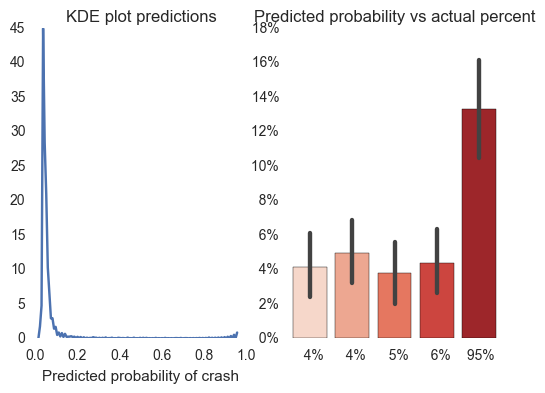

In [679]:
fig, axes = plt.subplots(1, 2)
lift_chart('categories', 'crash', risk_df, ax=axes[1])
density(risk_df, 'risk_score', ax=axes[0])

### Check sensitivity to week
I predicted an arbitrary week as target here, but I'd like to see whether things change significantly if I change that week.  A good metric to measure that is brier score loss.  It'll be low throughout as the classifier doesn't perform great, but it shouldn't vary a huge amount.

In [681]:
for w in [20, 30, 40, 50]:
    crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','week']), 'crash', w)
    data_model = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')
    data_scaled = scale_data(data_model, scaler)
    df = Indata(data_scaled, 'target')
    #Create train/test split
    df.tr_te_split(.7)
    test = Tester(df)
    test.init_tuned(tune)
    test.run_tuned('LR_scaled', cal=False)

Train obs: 5420
Test obs: 2370
Fitting LR_scaled model with 8 features
f1_score:  0.0148148148148
brier_score:  0.0507867032165
Train obs: 5476
Test obs: 2314
Fitting LR_scaled model with 8 features
f1_score:  0.0582524271845
brier_score:  0.0390493831096
Train obs: 5436
Test obs: 2354
Fitting LR_scaled model with 8 features
f1_score:  0.0300751879699
brier_score:  0.0484921603385
Train obs: 5414
Test obs: 2376
Fitting LR_scaled model with 8 features
f1_score:  0.0268456375839
brier_score:  0.0550681654644
